In [1]:
#import library
from scipy.stats import norm
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
%matplotlib inline

Define the prior by multuvatiate distribution

In [2]:
mu_1= [0.,0.]

cov_1 = [[ 1,  0.],
        [ 0.,  1]]


In [3]:
## initial the model

c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
np.random.seed(121)
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

np.random.seed(121)
## define the log probability

# @tf.function
# def joint_log_post(D,theta1,theta2):
#     # define random variables prior
#     mvn = tfd.MultivariateNormalTriL(
#             loc = mu_1,
#             scale_tril=tf.linalg.cholesky(cov_1))
#     z = tf.stack([theta1, theta2], axis=-1)
#     # define likelihood
#     y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
#     # return the posterior probability
#     return(mvn.log_prob(tf.squeeze(z))
#           +tf.reduce_sum(y.log_prob(D)))

In [4]:
## New joint posterior function with input vectorised 
@tf.function
def joint_log_post(z):
    # define random variables prior
    D_n = tf.reshape(D,[D.shape[0],1])
    D_n = tf.tile(D_n,[1,z.shape[0]])

    mvn = tfd.MultivariateNormalTriL(
            loc = mu_1,
            scale_tril=tf.linalg.cholesky(cov_1))

    # define likelihood
    y = tfd.Normal(loc = tf.add(z[:,1],tf.pow(z[:,0],2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D_n),axis = 0))

In [5]:
x_1, y_1 = np.mgrid[-2:2:.03, -2:2:.03]
pos = np.empty(x_1.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x_1; pos[:, :, 1] = y_1
pos = tf.convert_to_tensor(pos)

def full_post():
    post = np.empty(x_1.shape)
    for i in range(np.arange(-2,2,.03).shape[0]):
        for j in range(np.arange(-2,2,.03).shape[0]):
            post[i][j] = joint_log_post(tf.convert_to_tensor([pos[i][j]]))
    return post

post =  full_post()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [6]:
print('x:',x_1[np.unravel_index(np.argmax(post),post.shape)])
print('y',y_1[np.unravel_index(np.argmax(post),post.shape)])

x: 0.009999999999999787
y 0.040000000000000036


In [7]:
np.unravel_index(np.argmax(post),post.shape)

(67, 68)

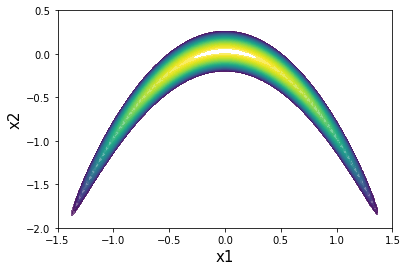

In [8]:
# levels = np.arange(joint_log_post(D,-0.,-0.2), joint_log_post(D,-0.,-0.0), 
#                    (joint_log_post(D,-0.,-0.0)- joint_log_post(D,-0.,-0.2))/20)
Min = tf.constant([[-0.,-0.2]])
Max = tf.constant([[0.0099,0.04]])
levels = np.arange(joint_log_post(Min), joint_log_post(Max), (joint_log_post(Max)- joint_log_post(Min))/50)

def draw_post():
#     plt.contourf(x_1, y_1, post,[joint_log_post(D,-0.,-0.13)])
    plt.contourf(x_1, y_1, post,levels = levels,alpha = 0.7)

    plt.xlim(-1.5,1.5)
    plt.ylim(-2,0.5)
    plt.xlabel("x1",fontsize = 15)
    plt.ylabel("x2",fontsize = 15)
draw_post()

##TODO modify the color map

## <b>RMH

Adjust the step size

In [9]:
initial_chain_state = tf.constant([[-1.,-1.]])

In [10]:
num_results = 5000
burnin = 100

initial_chain_state = tf.constant([[-1.,-1.]])
dtype = np.float32

@tf.function
def unnormalized_posterior_log_prob(*args):
    return joint_log_post(*args)

# adjust the step size of Random walk Matroplis Hasting MCMC
def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

@tf.function
def run_chain_RWMC(scale):
    samples, kernel_results= tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=burnin,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            new_state_fn=gauss_new_state_fn(scale=scale, dtype=dtype),
            seed=42))  # For determinism.
    return samples,kernel_results

samples,kernel_results = run_chain_RWMC(0.1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [11]:
##### Test the sensitivity of learning rate 
# acc = []
# for scale in np.arange(0.1,1,0.1):
#     _,kernel_results_ = run_chain_RWMC(scale)
#     accepted_ = kernel_results_.is_accepted
#     print('Acceptance rate: %0.1f%%' % (100*tf.reduce_mean(tf.cast(accepted_, dtype=tf.float32))))
#     acc.append(tf.reduce_mean(tf.cast(accepted_, dtype=tf.float32)))
# plt.title('Matroplis Hasting acceptance rate against step size')
# plt.ylabel('acceptance rate')
# plt.xlabel('step size')
# plt.plot(np.arange(0.1,1,0.1),acc)
# plt.savefig('/Users/zhouji/Documents/Results/Banana/Randomw_walk_step.png')

Acceptance rate: 61.7%


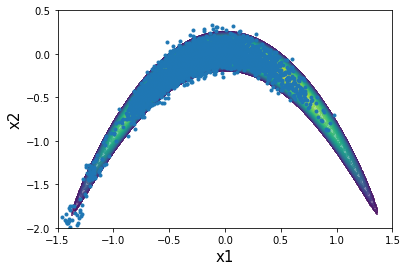

In [12]:
x_accepted_RW = samples[0,0,np.where(accepted ==True)[0]]
y_accepted_RW = samples[0,1,np.where(accepted ==True)[0]]

plt.plot(x_accepted_RW,y_accepted_RW,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted_RW.shape[0]/num_results)))
draw_post()

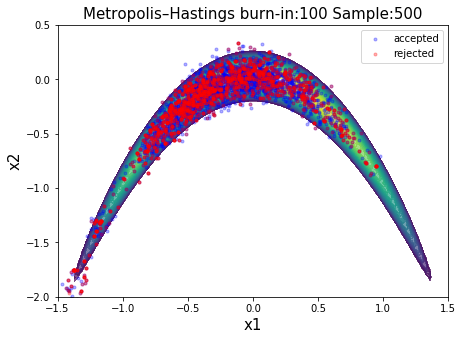

In [13]:
plt.figure(figsize=(7,5))
draw_post()
x_accepted_RW = samples[0,0,np.where(accepted ==True)[0]]
y_accepted_RW = samples[0,1,np.where(accepted ==True)[0]]
x_rejected_RW = samples[0,0,np.where(accepted ==False)[0]]
y_rejected_RW = samples[0,1,np.where(accepted ==False)[0]]

plt.xlim(-1.5,1.5)
plt.ylim(-2,0.5)
plt.title('Metropolis–Hastings burn-in:100 Sample:500',fontsize = 15)
plt.plot(x_accepted_RW,y_accepted_RW,'b.',label = 'accepted',alpha = 0.3)
plt.plot(x_rejected_RW,y_rejected_RW,'r.',label = 'rejected',alpha = 0.3)
        
plt.legend(loc = 'upper right')
# plt.savefig('/Users/zhouji/Documents/Results/Banana/Banana_randomwalk.png')

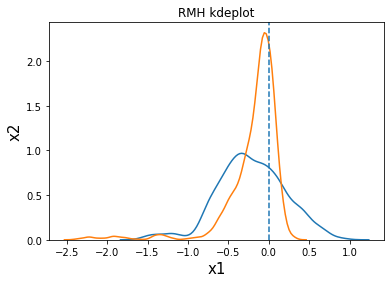

In [14]:
sns.kdeplot(x_accepted_RW)
sns.kdeplot(y_accepted_RW)

plt.xlabel("x1",fontsize = 15)
plt.ylabel("x2",fontsize = 15)
plt.title('RMH kdeplot')
plt.axvline(x=0, linestyle='--')
# plt.savefig('/Users/zhouji/Documents/Results/Banana/kde_RMH.png')

<b> HMC

In [15]:
@tf.function
def run_HMC():
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            step_size = 0.02,
            num_leapfrog_steps = 3),
        num_burnin_steps=burnin,
        num_steps_between_results=1,  # Thinning.
        parallel_iterations=1)
    return samples,kernel_results

samples,kernel_results = run_HMC()

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 99.2%


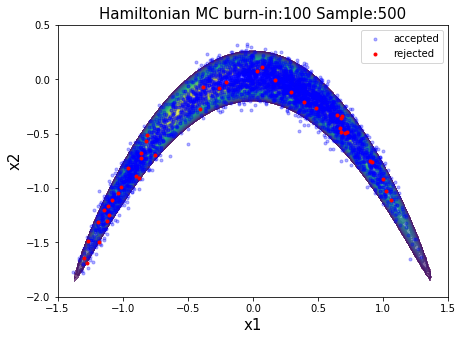

In [16]:
plt.figure(figsize=(7,5))
draw_post()
x_accepted_HMC = samples[0,0,np.where(accepted ==True)[0]]
y_accepted_HMC = samples[0,1,np.where(accepted ==True)[0]]
x_rejected_HMC = samples[0,0,np.where(accepted ==False)[0]]
y_rejected_HMC = samples[0,1,np.where(accepted ==False)[0]]

plt.xlim(-1.5,1.5)
plt.ylim(-2,0.5)
plt.title('Hamiltonian MC burn-in:100 Sample:500',fontsize = 15)
plt.plot(x_accepted_HMC,y_accepted_HMC,'b.',label = 'accepted',alpha = 0.3)
plt.plot(x_rejected_HMC,y_rejected_HMC,'r.',label = 'rejected',alpha = 1)
        
plt.legend(loc = 'upper right')
print('Acceptance rate: %0.1f%%' % (100*(x_accepted_HMC.shape[0]/num_results)))
plt.savefig('/Users/zhouji/Documents/Results/Banana/Banana_HMC.png')

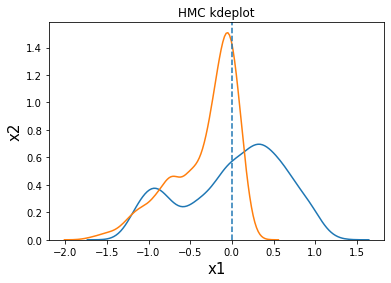

In [17]:
sns.kdeplot(x_accepted_HMC)
sns.kdeplot(y_accepted_HMC)

plt.xlabel("x1",fontsize = 15)
plt.ylabel("x2",fontsize = 15)
plt.title('HMC kdeplot')
plt.axvline(x=0, linestyle='--')
plt.savefig('/Users/zhouji/Documents/Results/Banana/kde_HMC.png')

<b> Hessian MCMC - banana v1.0

Set up the target probability density

<b> Gradient Descent

In [18]:
## Block out in case run by accident, takes too long to run 28 min
steps = 10000
@tf.function()
def gradient_decent():
    mu = tf.constant([[-0.1, -0.]])
    for i in tf.range(steps):
        with tf.GradientTape() as t:  
            t.watch(mu)
            loss = tf.negative(joint_log_post(mu))
            dlossdmu = t.gradient(loss,mu)
            mu = mu - 0.001*dlossdmu
    return mu


Let's take (0,0) as MAP for now

In [19]:
MAP = gradient_decent()

A new hessian function 2019-11-27

In [20]:
@tf.function
def Full_Hessian():
    Hess = tf.TensorArray(tf.float32, size=2)
    j=0
    for i in range(2):
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = -joint_log_post(MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[0][i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()

New_Hessian = tf.squeeze(Full_Hessian())

In [21]:
New_Hessian

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 9.3812490e-01, -1.7639652e-03],
       [-1.7639650e-03,  1.0100000e+02]], dtype=float32)>

#### Compute the Hessian and Covariance of the Posterior at MAP

Laplace approximation

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [22]:
cov= [[1.,0.],[0.,1.]]
cov = tf.convert_to_tensor(cov,dtype = tf.float32)
tf.linalg.inv(cov)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [23]:
# C_post = [[5.3157514e-01, 2.5224808e-04],
#        [2.5224808e-04, 9.8040411e-03]]

In [24]:
Sum = 0
Sum = tf.add(New_Hessian,tf.linalg.inv(cov))
C_post = tf.linalg.inv(Sum)
C_post

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[5.1596260e-01, 8.9229425e-06],
       [8.9229416e-06, 9.8039219e-03]], dtype=float32)>

Text(0, 0.5, 'x2')

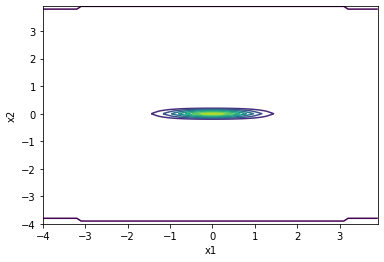

In [25]:
from scipy.stats import multivariate_normal
loc  = [0.,0.]
cov = C_post
x, y = np.mgrid[-4:4:.1, -4:4:.1]
pos = np.empty(x.shape + (2,)) 
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(loc, cov)
plt.contour(x, y, rv.pdf(pos))
plt.xlabel("x1")
plt.ylabel("x2")

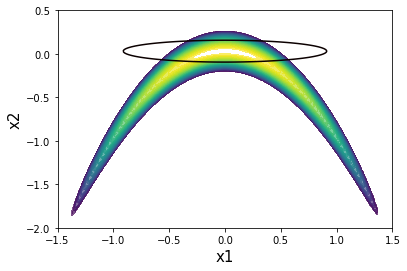

In [26]:

def plot_dist(loc,cov):
    x, y = np.mgrid[-4:4:.01, -4:4:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal(loc, cov)
#     plt.contour(x, y, rv.pdf(pos),np.arange(0.00001,0.0007,0.0001))
    plt.contour(x, y, rv.pdf(pos),[1.,3,10.], cmap=plt.get_cmap('hot'))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_dist(MAP[0],C_post)

draw_post() 

# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/hess_banana.png')

#### Define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}


gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

$\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}$  is the negative log posterior

In [27]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.squeeze(matrix1)
    matrix2 = tf.squeeze(matrix2)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

In [28]:
@tf.function
def negative_log_post(vars):
    return(tf.negative(joint_log_post(vars)))
@tf.function
def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.subtract(negative_log_post(m_current),matrixcompute(m_current,MAP,C_post))
    delta_proposed = tf.subtract(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,C_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        

In [29]:
from IPython.display import clear_output
# define leaning rate
beta = tf.constant(0.85)

@tf.function
def draw_proposal(m_current,beta):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.sqrt(1-beta**2)
    ## sqrt(1-beta^2)()
    _term2 = tem_1*(m_current-MAP)
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = _term1+_term2+_term3
    
    return m_proposed

In [30]:
mu_init = tf.constant([[-1.7,-1.5]])

In [31]:
number_of_steps = 10000

def run_chain():
    burn_in = 3000
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = MAP  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current,beta)

        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    accepted = tf.squeeze(accepted)
    rejected = tf.squeeze(rejected)
    return accepted,rejected

accepted,rejected = run_chain()

print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)



Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
acceptance rate = 26.9%


In [32]:
# for beta in np.arange(0.1,1,0.01):
#     accepted,rejected = run_chain()
#     print(beta)
#     print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))
#     accepted = np.array(accepted)

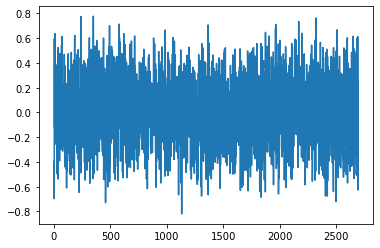

In [33]:
plt.plot(accepted[:,0])

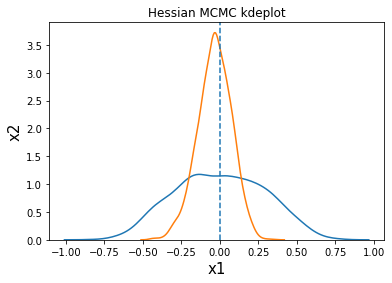

In [34]:
sns.kdeplot(accepted[:,0])
sns.kdeplot(accepted[:,1])

plt.xlabel("x1",fontsize = 15)
plt.ylabel("x2",fontsize = 15)
plt.title('Hessian MCMC kdeplot')
plt.axvline(x=0, linestyle='--')
# plt.savefig('/Users/zhouji/Documents/Results/Banana/kde_Hess.png')

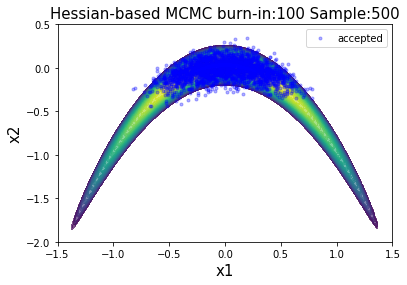

In [35]:
# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
accepted = np.array(accepted)
rejected = np.array(rejected)

plt.title('Hessian-based MCMC burn-in:100 Sample:500',fontsize = 15)
plt.plot(accepted[:,0],accepted[:,1],'b.',label = 'accepted',alpha = 0.3)
# plt.plot(rejected[:,0],rejected[:,1],'r.',label = 'rejected',alpha = 0.3)
plt.legend(loc = 'upper right')
draw_post()
# plt.savefig('/Users/zhouji/Documents/Results/Banana/Hessian_MCMC.png')

In [36]:
## New joint posterior function with input vectorised 
@tf.function
def log_likelihood(z):

    D_n = tf.reshape(D,[D.shape[0],1])
    D_n = tf.tile(D_n,[1,z.shape[0]])

    # define likelihood
    y = tfd.Normal(loc = tf.add(z[:,1],tf.pow(z[:,0],2.)), scale = sigma2y)
    # return the posterior probability
    return  tf.reduce_sum(y.log_prob(D_n),axis = 0)

In [37]:
@tf.function
def acceptance_pCN(m_current , m_proposed):
    delta_current = -log_likelihood(m_current)
    delta_proposed = -log_likelihood(m_proposed)
    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

There was a mistake here

### Modify the pCN proposal

In [38]:
@tf.function
def draw_proposal_pCN(m_current,beta):
    
    term_1 = mu_1
    ## sqrt term
    tem_1 = tf.sqrt(1-beta**2)
    ## sqrt(1-beta^2)()
    _term2 = tem_1 * (m_current -mu_1)
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= cov_1)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(term_1,tf.add(_term2,_term3))
    
    return m_proposed

In [39]:
num_results = 5000
burnin = 1000

beta = 0.4

def run_chain(beta):
    burn_in = burnin
    steps = num_results
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal_pCN(m_current,beta)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        
        if acceptance_pCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
            
    accepted = tf.squeeze(accepted).numpy()
    rejected = tf.squeeze(rejected).numpy()
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain(beta)

In [40]:
print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

acceptance rate = 11.8%


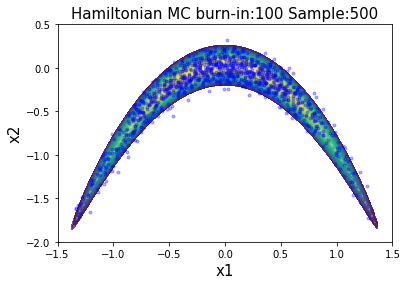

In [41]:
accepted = np.array(accepted)
rejected = np.array(rejected)

plt.title('Hamiltonian MC burn-in:100 Sample:500',fontsize = 15)
plt.plot(accepted[:,0],accepted[:,1],'b.',label = 'accepted',alpha = 0.3)
# plt.plot(rejected[:,0],rejected[:,1],'r.',label = 'rejected',alpha = 0.3)
draw_post()


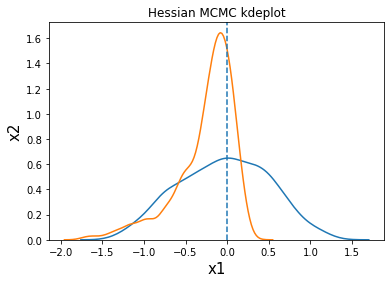

In [42]:
sns.kdeplot(accepted[:,0])
sns.kdeplot(accepted[:,1])

plt.xlabel("x1",fontsize = 15)
plt.ylabel("x2",fontsize = 15)
plt.title('Hessian MCMC kdeplot')
plt.axvline(x=0, linestyle='--')

## Now is gpCN

### Stein Variational method

In [43]:
def svgd_kernel(X0):
    XY = tf.matmul(X0, tf.transpose(X0))
    X2_ = tf.reduce_sum(tf.square(X0), axis=1)

    x2 = tf.reshape( X2_, shape=( tf.shape(X0)[0], 1) )
    
    X2e = tf.tile(x2, [1, tf.shape(X0)[0] ] )
    ## (x1 -x2)^2 + (y1 -y2)^2
    H = tf.subtract(tf.add(X2e, tf.transpose(X2e) ), 2 * XY)

    V = tf.reshape(H, [-1,1]) 

    # median distance
    def get_median(v):
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2
        return tf.nn.top_k(v, m).values[m-1]
    h = get_median(V)
    h = tf.sqrt(0.5 * h / tf.math.log( tf.cast( tf.shape(X0)[0] , tf.float32) + 1.0))

    # compute the rbf kernel
    Kxy = tf.exp(-H / h ** 2 / 2.0)

    dxkxy = -tf.matmul(Kxy, X0)
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=1), 1) 
    dxkxy = tf.add(dxkxy, tf.multiply(X0, sumkxy)) / (h ** 2)

    return (Kxy, dxkxy)

def get_median(v):
    v = tf.reshape(v, [-1])
    m = v.get_shape()[0]//2
    return tf.nn.top_k(v, m).values[m-1]



In [44]:
dtype = tf.float32
num_particles=250
num_latent = 2
lr = 0.003
alpha=.9
fudge_factor = 1e-6
num_iter = 5000
range_limit = [-3,3]
npoints_plot=50

In [45]:
z_np = tf.convert_to_tensor(-np.random.randn(num_particles, num_latent)*2.0,dtype = tf.float32)

In [46]:
@tf.function
def joint_log_post(z):
    # define random variables prior
    D_n = tf.reshape(D,[D.shape[0],1])
    D_n = tf.tile(D_n,[1,num_particles])

    mvn = tfd.MultivariateNormalTriL(
            loc = mu_1,
            scale_tril=tf.linalg.cholesky(cov_1))

    # define likelihood
    y = tfd.Normal(loc = tf.add(z[:,1],tf.pow(z[:,0],2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D_n),axis = 0))

In [47]:
@tf.function
def gradient(z_np):
    with tf.GradientTape() as t:
        t.watch(z_np)
        f = joint_log_post(z_np)
    log_p_grad = tf.squeeze(t.gradient(f,z_np))
    return log_p_grad

In [48]:
def run_chain_svgd():
    global z_np
    for _ in range(num_iter):
        log_p_grad = gradient(z_np)
        kernel_matrix, kernel_gradients = svgd_kernel(z_np)
        grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
        z_np = z_np+lr*grad_theta

In [49]:
run_chain_svgd()

In [50]:
log_p_grad = gradient(z_np)

kernel_matrix, kernel_gradients = svgd_kernel(z_np)

grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles

Text(0.5, 1.0, 'Initial particles: $p_0(z)$')

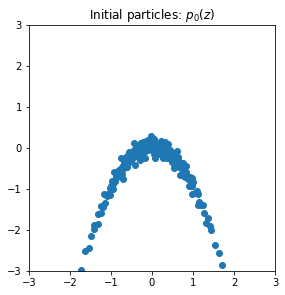

In [51]:
fig, _ = plt.subplots(figsize=(15, 7))
ax=plt.subplot(1,3,1, aspect='equal')
plt.scatter(z_np[:,0], z_np[:,1])  
plt.xlim(range_limit); plt.ylim(range_limit); ax.set_title('Initial particles: $p_0(z)$')


In [52]:
for _ in range(num_iter):
    log_p_grad = gradient(z_np)
    kernel_matrix, kernel_gradients = svgd_kernel(z_np)
    grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
    z_np = z_np+lr*grad_theta

Text(0.5, 1.0, 'Updated particles: $p_k(z)$')

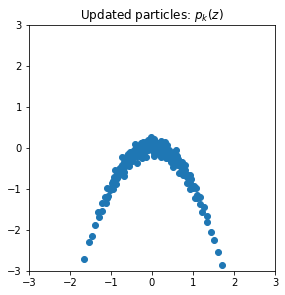

In [53]:
fig, _ = plt.subplots(figsize=(15, 7))
ax=plt.subplot(1,3,1, aspect='equal')
plt.scatter(z_np[:,0], z_np[:,1])
plt.xlim(range_limit); plt.ylim(range_limit); ax.set_title('Updated particles: $p_k(z)$')

In [54]:
with tf.GradientTape() as t:
    t.watch(z_np)
    f = joint_log_post(z_np)
tf.squeeze(t.gradient(f,z_np))

<tf.Tensor: shape=(250, 2), dtype=float32, numpy=
array([[ 5.96961141e-01,  2.05730033e+00],
       [-1.36005676e+00, -1.52852905e+00],
       [ 3.10914917e+01,  1.82997017e+01],
       [ 2.40070686e+01, -1.16218700e+01],
       [ 1.19111729e+00,  1.68097267e+01],
       [ 7.69949245e+00, -1.44062271e+01],
       [-2.85000539e+00,  5.07028532e+00],
       [ 6.72384405e+00, -1.54878769e+01],
       [-4.70987368e+00, -6.40441704e+00],
       [-5.53685606e-01,  4.60540438e+00],
       [-2.36834788e+00,  2.71274042e+00],
       [ 8.06756616e-01,  1.07596898e+00],
       [-1.65727890e+00,  2.20216441e+00],
       [ 6.88822937e+00, -2.94495249e+00],
       [-8.56462574e+00, -1.85662880e+01],
       [-7.57843113e+00,  8.09707546e+00],
       [ 4.31674910e+00,  7.68980694e+00],
       [ 2.65873375e+01, -9.12223911e+00],
       [-3.45432701e+01, -2.04684982e+01],
       [ 3.08497047e+00, -1.59664640e+01],
       [-3.60474539e+00,  3.88077021e+00],
       [ 1.22561097e+00, -4.97703493e-01],
    

## Make animation

In [55]:
from matplotlib import animation, rc
from IPython.display import HTML

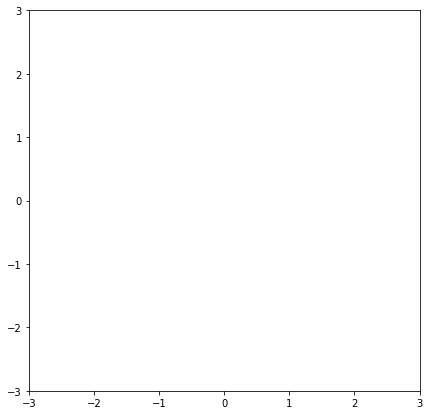

In [56]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlim(( -3, 3))
ax.set_ylim((-3, 3))



particels, = ax.plot(z_np[:,0], z_np[:,1],'o',ms =6,color = 'cornflowerblue')

z_np = tf.convert_to_tensor(-np.random.randn(num_particles, num_latent)*2.0,dtype = tf.float32)
lr = 0.002

def init():
    particels.set_data([], [])
    return (particels,)


def animate(i):
    global z_np, lr
    log_p_grad = gradient(z_np)
    kernel_matrix, kernel_gradients = svgd_kernel(z_np)
    grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
    z_np = z_np+lr*grad_theta
    particels.set_data(z_np[:,0], z_np[:,1])

    return (particels,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=2500, interval=20, blit=True)



In [57]:
HTML(anim.to_html5_video())

In [58]:
writer = animation.writers['ffmpeg'](fps=30)
anim.save('test.mp4',writer=writer,dpi=100)

Likelihood

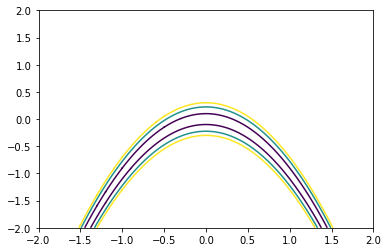

In [59]:
s = 0.01  # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-2, 2+s, s)   #Could use linspace instead if dividing
Y = np.arange(-2, 2.+s, s)   #evenly instead of stepping...

#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

Z =  (Y+X*X)**2

plt.contour(X,Y,Z,[0.01,0.05,0.09])

Prior

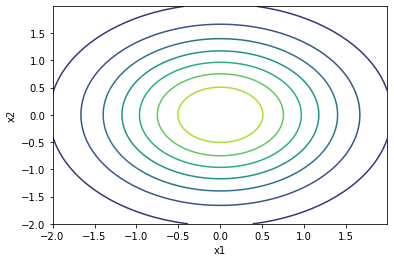

In [60]:
def plot_Prior():
    x, y = np.mgrid[-2:2:.01, -2:2:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    plt.contour(x, y, rv.pdf(pos))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_Prior()

Try again put them in a inference problem

In [61]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_post_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return (tf.exp(mvn.prob(tf.squeeze(z))
           +tf.reduce_sum(y.prob(D))))

In [62]:
# y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
# tf.reduce_prod(y.prob(D))

In [63]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

post = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        post[i][j] = joint_post_prob(D,pos[i][j][0],pos[i][j][1])

NameError: name 'mu' is not defined

In [ ]:
plt.contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")

#### make a function to plot the true density

In [ ]:
def plot_truepost():
    plt.contour(x, y, post)
    plt.xlim(-2,2)
    plt.ylim(-2,1)
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_truepost()

likelihood

In [ ]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def likelihood_prob(y,theta1,theta2):
    # define random variables prior
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)

    return(y.prob(D))

In [ ]:
# def multivariate_normal(x, d, mean, covariance):
#     """pdf of the multivariate normal distribution."""
#     x_m = x - mean
#     return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
#             np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [ ]:
def likelihood(mu,sigma,x):
    

In [ ]:
likelihood_prob(D,-1.,-1.)

In [ ]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y
likelihood = np.empty(x.shape)
for i in range(400):
    for j in range(400):
        likelihood[i][j] = likelihood_prob(D,pos[i][j][0],pos[i][j][1])

In [ ]:
plt.contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")
    

Prior

In [ ]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def prior_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    return(mvn.prob(tf.squeeze(z)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

prior = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        prior[i][j] = prior_prob(D,pos[i][j][0],pos[i][j][1])

In [ ]:
plt.contour(x, y, prior)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Let's add more observations, we shall expect broader extension

In [ ]:
c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.prob(tf.squeeze(z))
          +tf.reduce_sum(y.prob(D)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

pdf_1 = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        pdf_1[i][j] = joint_prob(D,pos[i][j][0],pos[i][j][1])

In [ ]:
plt.contour(x, y, pdf_1,[joint_prob(D,0.1,0.1).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Plot the results together

In [ ]:
likelihood_prob(D,-0.5,-0.35).numpy()

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].contour(x, y, prior)
ax[0].set_title('(a) Prior')

ax[1].contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
ax[1].set_ylim(-2,1)
ax[1].set_title('(b) Likelihood')

ax[2].contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
ax[2].set_ylim(-2,1)
ax[2].set_title('(c) Posterior')

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].contour(x, y, prior)
ax[0].set_title('(a) Prior')

ax[1].contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
ax[1].set_ylim(-2,1)
ax[1].set_title('(b) Likelihood')

ax[2].contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
ax[2].set_ylim(-2,1)
ax[2].set_title('(c) Posterior')

(a) Prior, (b) likelihood and (c) posterior for the warped bivariate Gaussian distribution with n=100 values generated from the likelihood with parameter settings $\sigma_y$,$\sigma$ = 11: as the sample size increases and the prior becomes more diffuse, the posterior becomes less identifiable and the ridge in the posterior becomes stronger 